# **New England Electric Power Operations 2010-2022**

An analysis of monthly and annual electric power operations by energy source for New England (2010-2022).



# I. Import Python Data Analysis Libraries

In [327]:
from ipywidgets.widgets.interaction import clear_output
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# II. Data Exploration

## A. Load Data and Inspect Features

The energy data is loaded from a CSV file.  The initial inspection checks that the fuel types have entries matching the number of periods in the dataset.  This dataset covers 2010 to 2022, so there are 156 monthly periods.  

The dataset is monthly and annual electric power operations by energy source. (Source: Form EIA-923). The data has been downloaded from the U.S. Energy Information Administration using their API.

Dataset Source URL:  https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=consumption-for-eg-btu&data[1]=generation&data[2]=total-consumption-btu&facets[location][]=NEW&facets[sectorid][]=98&start=2010-01&end=2022-12&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000

In [328]:
try:
    # Load the raw data from CSV
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/power_operations_98_data.csv')
    print("Raw data loaded successfully.\n")
except Exception as e:
    print("Failed to load raw data from CSV. Error:", str(e))

# Convert the 'period' column to datetime if it's not already
df['period'] = pd.to_datetime(df['period'])

# Select the relevant columns for analysis
columns = ['period', 'fueltypeid', 'fuelTypeDescription', 'consumption-for-eg-btu', 'generation', 'total-consumption-btu']

# Check the Fuel Types against the periods
def check_fuel_types_periods(period_count, df):
    # Set the count
    count = 0

    # Get the unique fuel types
    fuel_types = df['fuelTypeDescription'].unique()

    # Iterate over each fuel type
    for fuel_type in fuel_types:
        # Filter the DataFrame by fuel type
        filtered_df = df[df['fuelTypeDescription'] == fuel_type]

        # Count the number of rows
        row_count = filtered_df.shape[0]

        # Check if the row count does not match the period count
        if row_count != period_count:
            count += 1

            # Add title for the first entry in the list
            if count == 1:
                    print(f"Fuel types that do not match the number of periods ({period_count}) in the dataset.\n")
            print(f"Fuel Type: {fuel_type}, Row Count: {row_count}")

    # Notify if there are no fuel types with a mismatch to the period count
    if count == 0:
        print("All fuel types have the correct number of period values.")


# Check the Fuel Types against the periods
period_count = df['period'].nunique()
check_fuel_types_periods(period_count, df)

Raw data loaded successfully.

Fuel types that do not match the number of periods (156) in the dataset.

Fuel Type: petroleum, Row Count: 157
Fuel Type: petroleum liquids, Row Count: 157
Fuel Type: biomass, Row Count: 468
Fuel Type: hydro-electric pumped storage, Row Count: 155
Fuel Type: fossil fuels, Row Count: 155
Fuel Type: distillate fuel oil, Row Count: 155
Fuel Type: all fuels, Row Count: 157
Fuel Type: offshore wind turbine, Row Count: 73
Fuel Type: petroleum coke, Row Count: 1
Fuel Type: anthracite coal, Row Count: 10
Fuel Type: solar thermal, Row Count: 24
Fuel Type: other gases, Row Count: 12


## B.  Feature Selection and Identifying Data Problems

The fuel types containing data for less than 75% of the periods are specified for exclusion from the analysis.  In addition, hydro-electric pumped storage is excluded as it contains only generation data.  There is an adjustment made to the biomass description which contains 3 unique fuel type ids, so that description is renamed to include the fuel type id in the name.  

The periods with multiple entries or missing entries for a fuel type are identified for data cleaning.  Finally a count of rows that contain null values are identified and grouped by year.

In [329]:
# Fuel types to exclude, selected manually based on the output above
excluded_fuel_types = ['anthracite coal', 'hydro-electric pumped storage', 'offshore wind turbine',
                       'other gases', 'petroleum coke', 'solar thermal']

# Remove rows with excluded fuel types
df = df[~df['fuelTypeDescription'].isin(excluded_fuel_types)]

# Print excluded fuel types
print("Fuel types excluded from the analysis:")
print(excluded_fuel_types)
print()

# Define the fuel type description to be description plus type id
def update_fuel_type_description(fuel_type_description):
    # Get the unique fuel type IDs for the given fuel type description
    unique_fuel_type_ids = df.loc[df['fuelTypeDescription'] == fuel_type_description, 'fueltypeid'].unique()

    # Iterate over the unique fuel type IDs and update the fuel type descriptions
    for fuel_type_id in unique_fuel_type_ids:
        new_fuel_type_description = f"{fuel_type_description} ({fuel_type_id})"
        df.loc[(df['fuelTypeDescription'] == fuel_type_description) & (df['fueltypeid'] == fuel_type_id), 'fuelTypeDescription'] = new_fuel_type_description

# Identify periods with multiple entries for a fuel type
def identify_periods_with_multiple_entries(df):
    # Set the count
    count = 0

    # Iterate over each unique period
    for period in df['period'].unique():
        # Filter the DataFrame for the current period
        period_df = df[df['period'] == period]

        # Extract unique fuel types for the current period
        unique_fuel_types = period_df['fuelTypeDescription'].unique()

        # Check if there are multiple values for any fuel type in the current period
        for fuel_type in unique_fuel_types:
            fuel_type_count = period_df[period_df['fuelTypeDescription'] == fuel_type].shape[0]

            if fuel_type_count > 1:
                print("Multiple values for fuel type:", fuel_type, "\n", period, "\n")
                count += 1
    
    # Notify if there are no periods with multiple entries
    if count == 0:
        print("No periods with multiple entries")

# Identify periods with missing entries for a fuel type
def identify_periods_with_missing_entries(df):
    # Get the unique periods from the DataFrame
    unique_periods = df['period'].unique()
    
    # Get the unique fuel types from the DataFrame
    unique_fuel_types = df['fuelTypeDescription'].unique()

    # Set the count
    count = 0
    
    # Iterate over each period and fuel type
    for period in unique_periods:
        for fuel_type in unique_fuel_types:
            # Check if the combination of period and fuel type is missing in the DataFrame
            if len(df[(df['period'] == period) & (df['fuelTypeDescription'] == fuel_type)]) == 0:
                print("Missing entry for fuel type:", fuel_type, "\n", period, "\n")
                count += 1
    
    # Notify if there are no periods with missing entries
    if count == 0:
        print("No periods with missing entries")

# Count rows with missing values
def count_missing_rows(df):
    missing_rows_count = df[columns].isnull().any(axis=1).sum()
    print("\nRows with missing values:", missing_rows_count)

def show_missing_by_year(df):
    count = count_missing_rows(df)
    print()

    # Extract the year from the 'period' column
    df['year'] = df['period'].dt.year
    
    # Group the rows with missing values by year
    missing_rows_grouped = df[df[columns].isnull().any(axis=1)].groupby('year')

    # Print rows with missing values grouped by year
    for year, rows in missing_rows_grouped:
      print(f"Year: {year}")
      #print(rows)
      print(f"Count: {rows.shape[0]}\n")

# Print rows with missing values
def print_rows_with_missing_values(df):
    # Create a boolean mask for missing values
    mask = df.isnull().any(axis=1)

    # Filter the DataFrame using the mask
    rows_with_missing_values = df[mask]

    # Print the rows with missing values
    print(rows_with_missing_values)


# Fix biomass description
fuel_type_description = "biomass"
update_fuel_type_description(fuel_type_description)

# Identify periods with multiple entries for a fuel type
identify_periods_with_multiple_entries(df)

# Identify periods with missing entries for a fuel type
identify_periods_with_missing_entries(df)

# Show count of missing values grouped by year
show_missing_by_year(df)

Fuel types excluded from the analysis:
['anthracite coal', 'hydro-electric pumped storage', 'offshore wind turbine', 'other gases', 'petroleum coke', 'solar thermal']

Multiple values for fuel type: all fuels 
 2010-08-01T00:00:00.000000000 

Multiple values for fuel type: petroleum 
 2010-08-01T00:00:00.000000000 

Multiple values for fuel type: petroleum liquids 
 2010-08-01T00:00:00.000000000 

Missing entry for fuel type: fossil fuels 
 2010-08-01T00:00:00.000000000 

Missing entry for fuel type: distillate fuel oil 
 2010-08-01T00:00:00.000000000 


Rows with missing values: 31

Year: 2018
Count: 4

Year: 2022
Count: 27



## C.  Data Cleaning

Data cleaning fixes the issues identified in the last step, and consists of:

1.   Remove duplicate entries for a fuel type in a time period
2.   Adding missing entires for a fuel type for a time period
3.   Filling missing cell values with the mean value

In manually inspecting the data the extra entries identified above were duplicate values, so they are dropped.  The missing entries are added and then filled with the other cells missing data.  The missing cells were filled using the mean value for that category for the fuel type.

In [330]:
# Remove duplicate entries for periods with multiple values for a fuel type
def remove_duplicate_entries(df):
    # Set the count
    count = 0

    # Get the unique fuel types
    fuel_types = df['fuelTypeDescription'].unique()

    # Iterate over each fuel type
    for fuel_type in fuel_types:
        # Group the DataFrame by period and count the number of entries for each fuel type
        grouped_df = df[df['fuelTypeDescription'] == fuel_type].groupby('period').size()

        # Filter the grouped DataFrame to include periods with more than one entry
        duplicate_periods = grouped_df[grouped_df > 1]

        # Print the duplicate periods
        if not duplicate_periods.empty:

            # Iterate over each duplicate period
            for period in duplicate_periods.index:
                # Filter the DataFrame based on the period and fuel type
                selected_entries = df[(df['period'] == period) & (df['fuelTypeDescription'] == fuel_type)]

                # Delete the second entry
                df.drop(selected_entries.index[1], inplace=True)
                count += 1

    print("Duplicate rows removed:", count)

    return df

# Add missing entries for periods missing a value for a fuel type
def add_missing_rows(df):
    new_rows = []  # List to store the new rows

    unique_periods = df['period'].unique()
    unique_fuel_types = df['fuelTypeDescription'].unique()

    for period in unique_periods:
        for fuel_type in unique_fuel_types:
            filtered_df = df[(df['period'] == period) & (df['fuelTypeDescription'] == fuel_type)]
            if filtered_df.empty:
                new_row = {
                    'period': period,
                    'location': "NEW",
                    'stateDescription': "New England",
                    'sectorid': "98",
                    'sectorDescription': "Electric Power",
                    'fuelTypeDescription': fuel_type,
                    'consumption-for-eg-btu': np.nan,
                    'consumption-for-eg-btu-units': "million MMBtu",
                    'generation': np.nan,
                    'generation-units': "thousand megawatthours",
                    'total-consumption-btu': np.nan,
                    'total-consumption-btu-units': "million MMBtu"
                }
                new_rows.append(new_row)

    # Additional step to fill the fueltypeid using the fueTypeDescription
    # Convert the new rows to a DataFrame
    new_rows_df = pd.DataFrame(new_rows)

    # Create a DataFrame with distinct fuelTypeDescription and fueltypeid columns from the existing data
    fuel_types = df[['fuelTypeDescription', 'fueltypeid']].drop_duplicates()

    # Create a copy of new_rows list to add the fueltypeid values
    updated_new_rows = []

    # Iterate over the new rows
    for new_row in new_rows:
        fuel_type = new_row['fuelTypeDescription']
        
        # Find the corresponding fueltypeid from the fuel_types DataFrame
        fueltypeid = fuel_types.loc[fuel_types['fuelTypeDescription'] == fuel_type, 'fueltypeid'].values
        
        if len(fueltypeid) > 0:
            # Update the fueltypeid in the new row
            new_row['fueltypeid'] = fueltypeid[0]
        
        # Add the updated row to the list
        updated_new_rows.append(new_row)

    # Append the updated new rows to the existing DataFrame
    df = pd.concat([df, pd.DataFrame(updated_new_rows)], ignore_index=True)
    df = df.sort_values('period')
    
    num_rows_added = len(new_rows)
    print("New rows added:", num_rows_added)

    return df

def fill_missing_values(df):
    fuel_types = df['fuelTypeDescription'].unique()

    # Set count
    count = 0

    # Iterate over each fuel type
    for fuel_type in fuel_types:
        # Filter the DataFrame for the current fuel type
        fuel_type_df = df[df['fuelTypeDescription'] == fuel_type]

        # Calculate the mean values for each column
        mean_values = fuel_type_df.mean(numeric_only=True)

        # Fill missing values with the mean values
        df.loc[df['fuelTypeDescription'] == fuel_type] = df.loc[df['fuelTypeDescription'] == fuel_type].fillna(mean_values)

        count += fuel_type_df.isnull().sum().sum()

    if count > 0:
        print("Missing values filled for", count, "cells.")

    return df


# Remove duplicates
df = remove_duplicate_entries(df)

# Add missing rows
df = add_missing_rows(df)

# Fill missing data values
df = fill_missing_values(df)

Duplicate rows removed: 3
New rows added: 2
Missing values filled for 71 cells.


## D.  Data Verification and Export

The results of the data cleaning steps are shown and the cleaned dataset is exported to a CSV file.

In [331]:
# Count rows with missing values
count_missing_rows(df)

# Identify periods with multiple entries for a fuel type
identify_periods_with_multiple_entries(df)

# Identify periods with missing entries for a fuel type
identify_periods_with_missing_entries(df)

try:
    # Write the cleaned DataFrame to a CSV file
    df.to_csv('/content/drive/MyDrive/Colab Notebooks/power_operations_98_cleaned.csv', index=False)
    print("Cleaned data exported to CSV file: power_operations_98_cleaned.csv")
except Exception as e:
    print("Failed to export cleaned data to CSV file. Error:", str(e))



Rows with missing values: 0
No periods with multiple entries
No periods with missing entries
Cleaned data exported to CSV file: power_operations_98_cleaned.csv


# III. Descriptive Statistics:  Table of Summary Statistics by Fuel Type

The table of summary statistics displays the mean, standard deviation, minimum and maximum values.  By default the table shows all fuels calculated on an annual basis.  The table provides the option to choose between annual and monthly stats, and choice of fuel type to examine.

In [332]:
# Set the summary or plot widget buttons
def generate_widgets(df, instance_number, plot_function):
    def on_button_clicked(button):
        period = period_dropdown.value
        fuel_type = fuel_type_dropdown.value

        # Display the widgets again after an analysis
        display(widgets.VBox([period_dropdown, fuel_type_dropdown, button]))

        # Call the provided plot function with period and fuel_type arguments
        plot_function(df, period, fuel_type)

        # Display the widgets
        display(widgets.VBox([period_dropdown, fuel_type_dropdown, globals()[button_name]]))

    # Generate the initial table with annual for all fuels
    plot_function(df, "annual", "all fuels")

    # Create the dropdown widget for choosing the period type
    period_dropdown = widgets.Dropdown(
        options=['annual', 'monthly'],
        description=f'Period Type:',
        value='annual'
    )

    # Create the dropdown widget for choosing the fuel type
    fuel_type_dropdown = widgets.Dropdown(
        options=sorted(df['fuelTypeDescription'].unique()),  # Sort the fuel types alphabetically
        description=f'Fuel Type:',
        value='all fuels'
    )

    # Define a button widget to trigger the analysis and plots
    button_name = f'button{instance_number}'
    globals()[button_name] = widgets.Button(description=f'Show Data')

    # Register the on_button_clicked function to be called when the button is clicked
    globals()[button_name].on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([period_dropdown, fuel_type_dropdown, globals()[button_name]]))

In [333]:
# Descriptive Statistics: Table of Summary Statistics by Fuel Type
def generate_summary_table(df, summary_type, fuel_type):
    # Filter the data based on the user-selected level and fuel type
    if summary_type == 'annual':
        filtered_data = df[df['fuelTypeDescription'] == fuel_type].groupby(['fuelTypeDescription', pd.Grouper(key='period', freq='Y')]).sum(numeric_only=True).reset_index()
    elif summary_type == 'monthly':
        filtered_data = df[df['fuelTypeDescription'] == fuel_type].groupby(['fuelTypeDescription', pd.Grouper(key='period', freq='M')]).sum(numeric_only=True).reset_index()
    else:
        raise ValueError('Invalid level selected')

    # Calculate the summary statistics for each column
    consumption_stats = filtered_data.groupby('fuelTypeDescription')['consumption-for-eg-btu'].agg(['mean', 'std', 'min', 'max'])
    generation_stats = filtered_data.groupby('fuelTypeDescription')['generation'].agg(['mean', 'std', 'min', 'max'])
    total_consumption_stats = filtered_data.groupby('fuelTypeDescription')['total-consumption-btu'].agg(['mean', 'std', 'min', 'max'])

    # Calculate the count based on the number of rows in filtered_data
    count = filtered_data.shape[0]

    # Clear the previous result
    clear_output()

    # Print the title with count
    title = f'Summary Statistics for {summary_type} ({fuel_type}), Count: {count}'
    print(title)
    print()

    # Print consumption-for-eg-btu statistics
    print("Consumption-for-eg-btu (million MMBtu):")
    print(tabulate(consumption_stats, headers='keys', tablefmt='psql'))
    print()

    # Print generation statistics
    print("Generation (thousand megawatthours):")
    print(tabulate(generation_stats, headers='keys', tablefmt='psql'))
    print()

    # Print total-consumption-btu statistics
    print("Total-consumption-btu (million MMBtu):")
    print(tabulate(total_consumption_stats, headers='keys', tablefmt='psql'))

# Generate the summary table and buttons
generate_widgets(df, 0, generate_summary_table)

Summary Statistics for annual (all fuels), Count: 13

Consumption-for-eg-btu (million MMBtu):
+-----------------------+---------+---------+---------+---------+
| fuelTypeDescription   |    mean |     std |     min |     max |
|-----------------------+---------+---------+---------+---------|
| all fuels             | 976.824 | 91.8941 | 835.781 | 1164.36 |
+-----------------------+---------+---------+---------+---------+

Generation (thousand megawatthours):
+-----------------------+--------+---------+---------+--------+
| fuelTypeDescription   |   mean |     std |     min |    max |
|-----------------------+--------+---------+---------+--------|
| all fuels             | 105467 | 8618.69 | 93006.1 | 123441 |
+-----------------------+--------+---------+---------+--------+

Total-consumption-btu (million MMBtu):
+-----------------------+---------+---------+---------+---------+
| fuelTypeDescription   |    mean |     std |     min |     max |
|-----------------------+---------+---------+-

# IV. Data Visualization

## Visualization 1: Consumption for Electricity Generation vs Total Consumption

The plot of Consumption for Electricity Generation BTU by Fuel Type vs Total Consumption BTU allows exploration of the data in a visual format.  The choice of annual data presents a visual for year by year change, whereas the monthly data shows greater variability.

The plot provides the option to choose between annual and monthly stats, and choice of fuel type to examine.


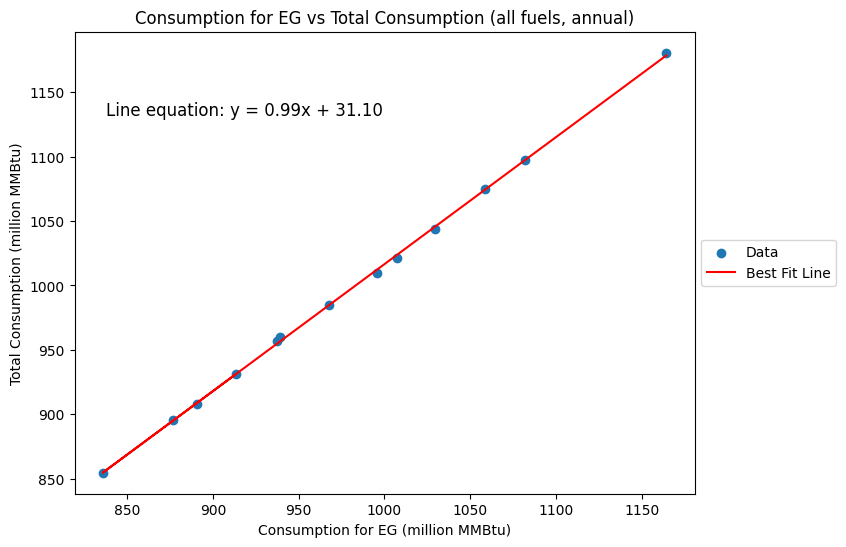

In [334]:
#Visualization #1
# Plot consumption for electricity generation vs total consumption
def plot_consumption_vs_total(df, summary_type, fuel_type):
    # Filter the data based on the user-selected level and fuel type
    if summary_type == 'annual':
        filtered_data = df[df['fuelTypeDescription'] == fuel_type].groupby(['fuelTypeDescription', pd.Grouper(key='period', freq='Y')]).sum(numeric_only=True).reset_index()
    elif summary_type == 'monthly':
        filtered_data = df[df['fuelTypeDescription'] == fuel_type].groupby(['fuelTypeDescription', pd.Grouper(key='period', freq='M')]).sum(numeric_only=True).reset_index()
    else:
        raise ValueError('Invalid level selected')

    # Extract the required columns
    consumption = filtered_data['consumption-for-eg-btu'].values.reshape(-1, 1)
    total_consumption = filtered_data['total-consumption-btu'].values

    # Clear the previous result
    clear_output()

    # Perform linear regression
    model = LinearRegression()
    model.fit(consumption, total_consumption)
    slope = model.coef_[0]
    intercept = model.intercept_
    line = model.predict(consumption)

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(consumption, total_consumption, label='Data')
    plt.plot(consumption, line, color='red', label='Best Fit Line')
    plt.xlabel('Consumption for EG (million MMBtu)')
    plt.ylabel('Total Consumption (million MMBtu)')
    plt.title(f'Consumption for EG vs Total Consumption ({fuel_type}, {summary_type})')

    # Display the equation on the plot
    equation = f'Line equation: y = {slope:.2f}x + {intercept:.2f}'
    plt.text(0.05, 0.85, equation, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    # Position the legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

generate_widgets(df, 1, plot_consumption_vs_total)

## Visualization 2: Total Generation by Fuel Type

The plot of Total Generation by Fuel Type allows exploration of the data in a visual format.  The choice of annual data presents a visual for year by year change, whereas the monthly data shows greater variability.

The plot provides the option to choose between annual and monthly stats, and choice of fuel type to examine.

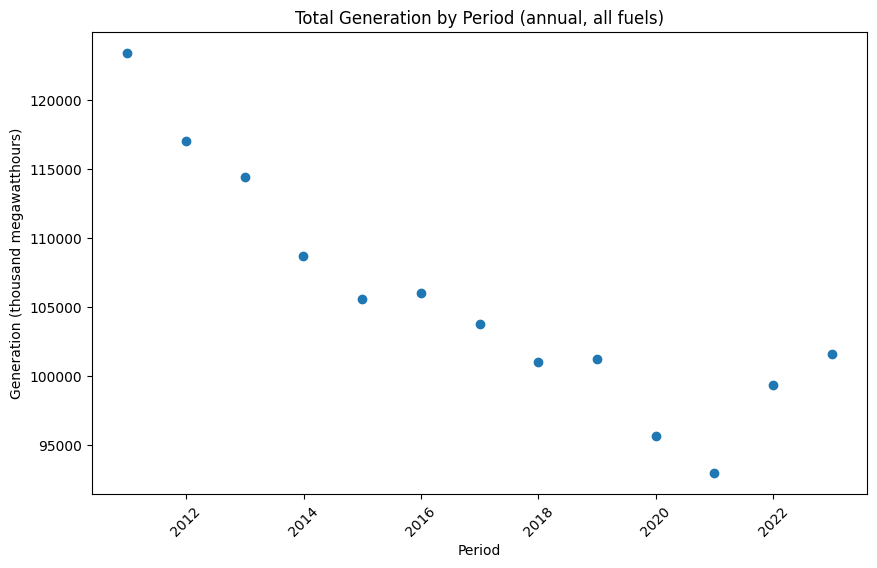

In [335]:
# Visualization 2
# Define the function to plot a scatter plot of generation and period
def plot_scatter_plot_generation(df, period, fuel_type):
    # Filter the data based on the user-selected level and fuel type
    if period == 'annual':
        filtered_data = df[df['fuelTypeDescription'] == fuel_type].groupby(['fuelTypeDescription', pd.Grouper(key='period', freq='Y')]).sum(numeric_only=True).reset_index()
    elif period == 'monthly':
        filtered_data = df[df['fuelTypeDescription'] == fuel_type].groupby(['fuelTypeDescription', pd.Grouper(key='period', freq='M')]).sum(numeric_only=True).reset_index()
    else:
        raise ValueError('Invalid level selected')

    # Clear previous plot
    clear_output()

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_data['period'], filtered_data['generation'])
    plt.xlabel('Period')
    plt.ylabel('Generation (thousand megawatthours)')
    plt.title(f'Total Generation by Period ({period}, {fuel_type})')
    plt.xticks(rotation=45)
    plt.show()

# Generate the plot and buttons
generate_widgets(df, 2, plot_scatter_plot_generation)


## Visualization 3: Total Consumption by Fuel Type

The plot of Total Consumption by Fuel Type allows exploration of the data in a visual format.  The choice of annual data presents a visual for year by year change, whereas the monthly data shows greater variability.

The plot provides the option to choose between annual and monthly stats, and choice of fuel type to examine.

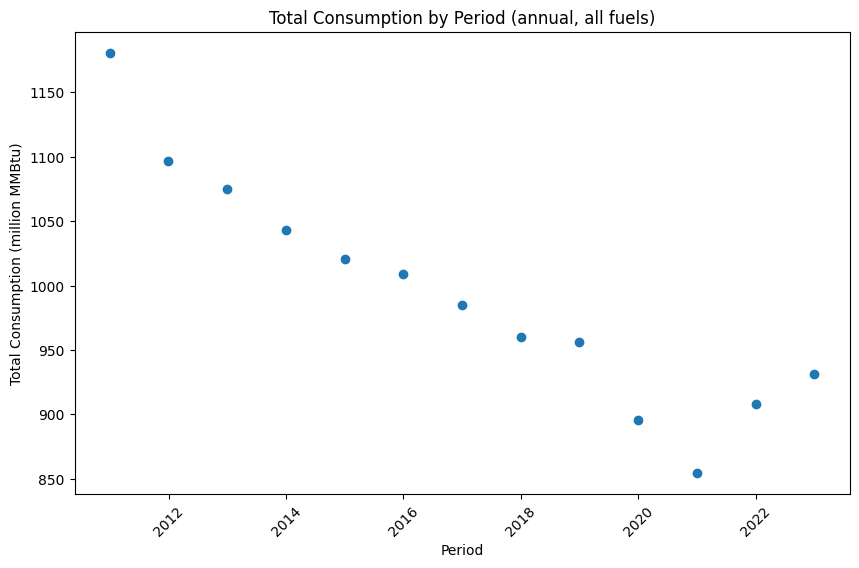

In [336]:
# Visualization 3
# Define the function to plot a scatter plot of total consumption and period
def plot_scatter_plot_total_consumption(df, level, fuel_type):
    # Filter the data based on the user-selected level and fuel type
    if level == 'annual':
        filtered_data = df[df['fuelTypeDescription'] == fuel_type].groupby(['fuelTypeDescription', pd.Grouper(key='period', freq='Y')]).sum(numeric_only=True).reset_index()
    elif level == 'monthly':
        filtered_data = df[df['fuelTypeDescription'] == fuel_type].groupby(['fuelTypeDescription', pd.Grouper(key='period', freq='M')]).sum(numeric_only=True).reset_index()
    else:
        raise ValueError('Invalid level selected')

    # Clear previous plot
    clear_output()

    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_data['period'], filtered_data['total-consumption-btu'])
    plt.xlabel('Period')
    plt.ylabel('Total Consumption (million MMBtu)')
    plt.title(f'Total Consumption by Period ({level}, {fuel_type})')
    plt.xticks(rotation=45)
    plt.show()

# Generate the plot and buttons
generate_widgets(df, 3, plot_scatter_plot_total_consumption)


# V.  Data Analysis

## A.  Model Dataset Preparation
The data is divided between train and test datasets.  The training set will be 2010 to 2018 and the test set will be 2019 to 2022.  A copy of each dataset is exported to CSV.

In [337]:
# Filter the data to cover the desired period
train_start_year = 2010
train_end_year = 2018
test_start_year = 2019
test_end_year = 2022

# Create the train and test data sets divided by years
train_data = df[(df['period'].dt.year >= train_start_year) & (df['period'].dt.year <= train_end_year)]
test_data = df[(df['period'].dt.year >= test_start_year) & (df['period'].dt.year <= test_end_year)]

# Export the train and test data sets to CSV
train_data.to_csv('/content/drive/MyDrive/Colab Notebooks/train_data.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/Colab Notebooks/test_data.csv', index=False)

## B.  Model Training  
Seasonal and Trend decomposition using Loess (STL) is used to analyze the training data.  Each month is broken down into a trend, seasonal and residual component.  The trend is the overall trend line of the data and seasonal captures the seasonal variations in the data.  Residual reflects noise in the data which can not be attributed to the other components

The model is created with SARIMAX from the training data set then the STL decomposition.  The parameters for SARIMAX were optimized using pmdarima.  The model was then used to create predictions for the test set of 2019-2022 and to make additional forecasts for 2023-2025.

The graph shows the training data as the original data, trend, seasonal, and residual components.  The fuel type can be selected on the graph to explore the different fuel types in the training data.

The SARIMAX Results table shows the model fit statistics for the training data to indicate how well the model represents the training data.


In [338]:
# Set the analysis plot widget buttons
def generate_analysis_widgets(df, instance_number, decomposition_result, plot_function):
    result = decomposition_result

    def on_button_clicked(button):
        fuel_type = fuel_type_dropdown.value
    
        # Call the provided plot function with period and fuel_type arguments
        plot_function(df, result, fuel_type)

        # Display the widgets again after an analysis
        display(widgets.VBox([fuel_type_dropdown, button]))
        
    # Generate the initial table with annual for all fuels
    plot_function(df, result, "all fuels")

    # Create the dropdown widget for choosing the fuel type
    fuel_type_dropdown = widgets.Dropdown(
        options=sorted(df['fuelTypeDescription'].unique()),  # Sort the fuel types alphabetically
        description=f'Fuel Type:',
        value='all fuels'
    )

    # Define a button widget to trigger the analysis and plots
    button_name = f'button{instance_number}'
    globals()[button_name] = widgets.Button(description=f'Show Analysis')

    # Register the on_button_clicked function to be called when the button is clicked
    globals()[button_name].on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([fuel_type_dropdown, globals()[button_name]]))

# Plot function for STL model
def plot_seasonal_decomposition(df, decomposition_results, fuelTypeDescription):
    df = df.copy()
    df['period'] = pd.to_datetime(df['period'])
    df_pivot = df.pivot_table(index='period', columns='fuelTypeDescription', values='total-consumption-btu')

    # Clear the previous plot
    clear_output()

    result = decomposition_results[fuelTypeDescription]

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    axes[0, 0].set_ylabel('Total Consumption (million MMBtu)')

    df_pivot[fuelTypeDescription].plot(ax=axes[0, 0], title=f'{fuelTypeDescription} - Original Data')
    result.trend.plot(ax=axes[0, 1], title=f'{fuelTypeDescription} - Trend Component')
    result.seasonal.plot(ax=axes[1, 0], title=f'{fuelTypeDescription} - Seasonal Component')
    result.resid.plot(ax=axes[1, 1], title=f'{fuelTypeDescription} - Residual Component')

    plt.tight_layout()
    plt.show()


In [339]:
print(train_data.columns)
print(train_data.values)
print(test_data.columns)

Index(['period', 'location', 'stateDescription', 'sectorid',
       'sectorDescription', 'fueltypeid', 'fuelTypeDescription',
       'consumption-for-eg-btu', 'consumption-for-eg-btu-units', 'generation',
       'generation-units', 'total-consumption-btu',
       'total-consumption-btu-units', 'year'],
      dtype='object')
[[Timestamp('2010-01-01 00:00:00') 'NEW' 'New England' ... 14.35826
  'million MMBtu' 2010.0]
 [Timestamp('2010-01-01 00:00:00') 'NEW' 'New England' ... 4.65863
  'million MMBtu' 2010.0]
 [Timestamp('2010-01-01 00:00:00') 'NEW' 'New England' ... 2.41654
  'million MMBtu' 2010.0]
 ...
 [Timestamp('2018-12-01 00:00:00') 'NEW' 'New England' ... 3.29299
  'million MMBtu' 2018.0]
 [Timestamp('2018-12-01 00:00:00') 'NEW' 'New England' ... 3.18819
  'million MMBtu' 2018.0]
 [Timestamp('2018-12-01 00:00:00') 'NEW' 'New England' ... 1.71649
  'million MMBtu' 2018.0]]
Index(['period', 'location', 'stateDescription', 'sectorid',
       'sectorDescription', 'fueltypeid', 'fuelT

In [352]:
# Use LSTM
# Prepare the training data
train_pivot = pd.pivot(train_data, index='period', columns='fuelTypeDescription', values='total-consumption-btu')
train_pivot = train_pivot.asfreq('MS')

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the training data
train_data_scaled = scaler.fit_transform(train_pivot)

# Prepare the testing data
test_pivot = pd.pivot(test_data, index='period', columns='fuelTypeDescription', values='total-consumption-btu')
test_pivot = test_pivot.asfreq('MS')

# Scale the testing data
test_data_scaled = scaler.transform(test_pivot)

def train_model(train_pivot, train_data_scaled, sequence_length=12):
    models = {}

    # Iterate over each fuel type
    for fuel_type in train_pivot.columns.tolist():
        print("Training model for fuel type:", fuel_type)

        # Get the scaled training data for the specific fuel type
        fuel_type_index = train_pivot.columns.get_loc(fuel_type)
        train_data_scaled_fuel = train_data_scaled[:, fuel_type_index].reshape(-1, 1)

        # Prepare the input sequences and target values for the specific fuel type
        X_train, y_train = [], []
        for i in range(sequence_length, len(train_data_scaled_fuel)):
            X_train.append(train_data_scaled_fuel[i - sequence_length:i, 0])
            y_train.append(train_data_scaled_fuel[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)

        # Create the LSTM model for the specific fuel type
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Fit the LSTM model to the training data for the specific fuel type
        model.fit(X_train, y_train, epochs=50, batch_size=32)

        # Store the model for the specific fuel type in the dictionary
        models[fuel_type] = model

    return models

# Set the test parameters for 2019-2022
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-12-31')
test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='MS')

# Create an empty DataFrame to store the forecast predictions
all_predictions = pd.DataFrame(index=test_dates, columns=train_pivot.columns)


# Iterate over each fuel type
for fuel_type in train_pivot.columns:
    print("Testing for fuel type:", fuel_type)
    
    # Get the model for the specific fuel type
    model = models[fuel_type]

    # Get the scaled testing data for the specific fuel type
    fuel_type_index = train_pivot.columns.get_loc(fuel_type)
    test_data_scaled_fuel = test_data_scaled[:, fuel_type_index].reshape(-1, 1)

    # Make predictions for the forecast period for the specific fuel type
    X_test = np.array([test_data_scaled_fuel[-sequence_length:]] * 48)
    X_test = X_test.reshape(48, sequence_length, 1)
    all_predictions_scaled_fuel = model.predict(X_test)

    # Reshape the predictions to match the expected shape
    all_predictions_fuel = all_predictions_scaled_fuel[:, -1].reshape(-1, 1)

    # Store the forecast predictions for the specific fuel type in the DataFrame
    all_predictions[fuel_type] = all_predictions_fuel.flatten()

# Print the predictions for the test data and forecast predictions
print(all_predictions)
print(models)

Testing for fuel type: all coal products
2/2 [==============================] - 0s 10ms/step
Testing for fuel type: all fuels
2/2 [==============================] - 0s 12ms/step
Testing for fuel type: all renewables
2/2 [==============================] - 0s 13ms/step
Testing for fuel type: biogenic municipal solid waste
2/2 [==============================] - 0s 11ms/step
Testing for fuel type: biomass (BIO)
2/2 [==============================] - 0s 9ms/step
Testing for fuel type: biomass (OB2)
2/2 [==============================] - 0s 10ms/step
Testing for fuel type: biomass (OBW)
2/2 [==============================] - 0s 9ms/step
Testing for fuel type: bituminous coal
2/2 [==============================] - 0s 11ms/step
Testing for fuel type: bituminous coal and synthetic coal
2/2 [==============================] - 0s 13ms/step
Testing for fuel type: coal, excluding waste coal
2/2 [==============================] - 0s 10ms/step
Testing for fuel type: conventional hydroelectric
2/2 [===

In [346]:
# Set the forecast parameters for 2023-2025
forecast_start_date = pd.to_datetime('2023-01-01')
forecast_end_date = pd.to_datetime('2025-12-31')
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='MS')

# Create an empty DataFrame to store the forecast predictions
forecast_predictions = pd.DataFrame(index=forecast_dates, columns=train_pivot.columns)

# Iterate over each fuel type
for fuel_type in train_pivot.columns:
    print("Forecasting for fuel type: ", fuel_type)
    # Get the model for the specific fuel type
    model = models[fuel_type]

    # Get the scaled training and testing data for the specific fuel type
    fuel_type_index = train_pivot.columns.get_loc(fuel_type)
    train_data_scaled_fuel = train_data_scaled[:, fuel_type_index].reshape(-1, 1)

    # Make predictions for the forecast period for the specific fuel type
    X_forecast = pd.concat([pd.DataFrame(test_data_scaled_fuel[-sequence_length:, 0]).T] * len(forecast_dates))
    X_forecast = X_forecast.values.reshape(-1, sequence_length, 1)
    forecast_predictions_scaled_fuel = model.predict(X_forecast)

    # Reshape the predictions to match the expected shape
    forecast_predictions_fuel = forecast_predictions_scaled_fuel[:, -1].reshape(-1, 1)

    # Store the forecast predictions for the specific fuel type in the DataFrame
    forecast_predictions[fuel_type] = forecast_predictions_fuel.flatten()

# Scale the forecast predictions back to the original data scale
forecast_predictions = scaler.inverse_transform(forecast_predictions)

# Convert the NumPy array to a DataFrame
#forecast_predictions = pd.DataFrame(data=forecast_predictions, index=forecast_dates, columns=train_pivot.columns)

# Print the forecast predictions
print(forecast_predictions)

Forecasting for fuel type:  all coal products
2/2 [==============================] - 0s 10ms/step
Forecasting for fuel type:  all fuels
2/2 [==============================] - 0s 8ms/step
Forecasting for fuel type:  all renewables
2/2 [==============================] - 0s 11ms/step
Forecasting for fuel type:  biogenic municipal solid waste
2/2 [==============================] - 0s 8ms/step
Forecasting for fuel type:  biomass (BIO)
2/2 [==============================] - 0s 12ms/step
Forecasting for fuel type:  biomass (OB2)
2/2 [==============================] - 0s 17ms/step
Forecasting for fuel type:  biomass (OBW)
2/2 [==============================] - 0s 14ms/step
Forecasting for fuel type:  bituminous coal
2/2 [==============================] - 0s 19ms/step
Forecasting for fuel type:  bituminous coal and synthetic coal
2/2 [==============================] - 0s 13ms/step
Forecasting for fuel type:  coal, excluding waste coal
2/2 [==============================] - 0s 14ms/step
Forecast

## C.  Model Testing

The test data is compared against the predictions for the test period (2019-2022) to see how the model performed.  

## A.  Plot Actual Values and Predicted Values

All the actual values (train and test) and predictions (test predictions and forecast) are plotted together to provide a visual look at the model accuracy.  The test actual values are plotted with the test predictionspredicted values to provide a detailed visual of how the values compare.  

In [342]:
# Set the evaluation plot widget buttons
def generate_eval_widgets(instance_number, fuel_type, train_pivot, test_pivot, all_predictions, forecast_predictions):

    def on_button_clicked(button):
        fuel_type = fuel_type_dropdown.value
    
        # Clear previous plot
        clear_output()

        # Call the provided plot function with period and fuel_type arguments
        plot_all(fuel_type, train_pivot, test_pivot, all_predictions, forecast_predictions)
        plot_predictions(fuel_type, test_pivot, all_predictions)

        # Display the widgets again after an analysis
        display(widgets.VBox([fuel_type_dropdown, button]))
        
    # Generate the initial table with annual for all fuels
    plot_all('all fuels', train_pivot, test_pivot, all_predictions, forecast_predictions)
    plot_predictions('all fuels', test_pivot, all_predictions)

    # Create the dropdown widget for choosing the fuel type
    fuel_type_dropdown = widgets.Dropdown(
        options=sorted(df['fuelTypeDescription'].unique()),  # Sort the fuel types alphabetically
        description=f'Fuel Type:',
        value='all fuels'
    )

    # Define a button widget to trigger the analysis and plots
    button_name = f'button{instance_number}'
    globals()[button_name] = widgets.Button(description=f'Show Analysis')

    # Register the on_button_clicked function to be called when the button is clicked
    globals()[button_name].on_click(on_button_clicked)

    # Display the widgets
    display(widgets.VBox([fuel_type_dropdown, globals()[button_name]]))

AttributeError: ignored

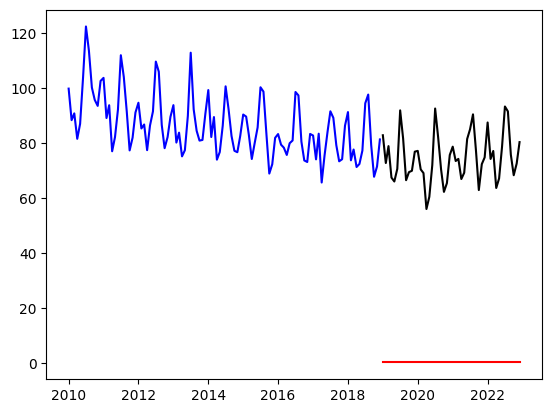

In [343]:
def evaluate_model(predictions, actual_values):
    mse = mean_squared_error(actual_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predictions)
    mfe = np.mean(actual_values - predictions)
    r2 = r2_score(actual_values, predictions)
    
    return mse, rmse, mae, mfe, r2

evaluation_metrics = {}
for fuel_type in train_results.keys():
    actual_values = test_pivot[fuel_type]
    predictions = all_predictions.loc[test_pivot.index, fuel_type]  # Extract predicted values for test dates
    mse, rmse, mae, mfe, r2 = evaluate_model(predictions, actual_values)
    evaluation_metrics[fuel_type] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MFE': mfe, 'R-squared': r2}

def plot_all(fuel_type, train_pivot, test_pivot, all_predictions, forecast_predictions):
    plt.figure()
    plt.plot(train_pivot.index, train_pivot[fuel_type], label='Train', color='blue')
    plt.plot(test_pivot.index, test_pivot[fuel_type], label='Test', color='black')
    plt.plot(all_predictions.index, all_predictions[fuel_type], label='Predicted', color='red')
    if forecast_predictions is not None:
        plt.plot(forecast_predictions.index, forecast_predictions[fuel_type], label='Forecast', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(fuel_type)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_predictions(fuel_type, test_pivot, all_predictions):
    plt.figure()
    plt.plot(test_pivot.index, test_pivot[fuel_type], label='Test', color='black')
    plt.plot(all_predictions.index, all_predictions[fuel_type], label='Predicted', color='red')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(fuel_type)
    plt.legend()
    plt.tight_layout()
    plt.show()

generate_eval_widgets(5, fuel_type, train_pivot, test_pivot, all_predictions, forecast_predictions)

In [ ]:
print(test_pivot.index)

## B. Model Evaluation Statistics for All Fuel Types

This table provides the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Forecase Error (MFE) and R-Squared Score for each of the fuel type models.  The second part of the table includes the mean and standard deviation for the test dataset, from which the ratios of MSE to the test mean and RMSE to the test standard deviation are calculated.

In [ ]:
evaluation_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')
print(evaluation_df)

## C. Models with Predictive Properties

The following models demonstrate predictive properties with an R-Squared score above .5.

In [ ]:
evaluation_df_filtered = evaluation_df[(evaluation_df['R-squared'] > 0.5)]
print(evaluation_df_filtered)
